In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose # ETS decompositon
from statsmodels.tsa.stattools import adfuller # Dickey Fuller Test for Stationarity
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # ACF and PACF plots
from statsmodels.tsa.arima_model import ARIMA # ARIMA models

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import itertools

In [5]:
#usage = pd.read_csv('../data/electricity_usage.csv',index_col='Date',parse_dates=True)
usage = pd.read_csv('../data/electricity_usage.csv', parse_dates= True)
usage.head()
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
Date     114 non-null object
Usage    108 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [6]:
# Date is not read in as DateTime. Convert it.
usage['Date'] = pd.to_datetime(usage['Date'])

In [7]:
# Fill NA values with rolling average of last 3 months
usage['Usage'].fillna(usage['Usage'].rolling(3,min_periods=1).mean(), inplace=True)
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
Date     114 non-null datetime64[ns]
Usage    114 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


In [8]:
usage = usage.set_index('Date').asfreq('M')
usage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2009-12-31 to 2019-05-31
Freq: M
Data columns (total 1 columns):
Usage    114 non-null float64
dtypes: float64(1)
memory usage: 1.8 KB


In [9]:
usage.index

DatetimeIndex(['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30',
               ...
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31'],
              dtype='datetime64[ns]', name='Date', length=114, freq='M')

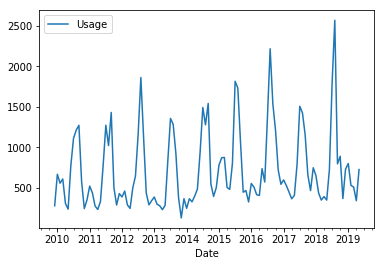

In [10]:
usage.plot()

In [11]:
#usage.fillna(usage['Usage'].shift(12),inplace=True)

In [12]:
#usage.info()

In [13]:
#usage.info()
#usage.plot()

<Figure size 864x576 with 0 Axes>

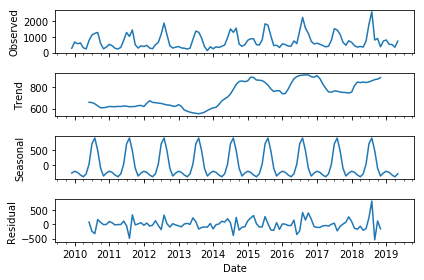

In [14]:
result = seasonal_decompose(usage['Usage'],model='additive', freq=12)
plt.figure(figsize = (12,8))
fig = result.plot() 

## Additive Model results in lot of error (residual)

<Figure size 864x576 with 0 Axes>

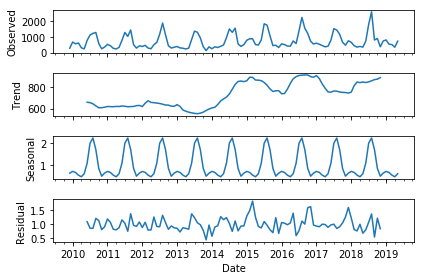

In [15]:
result = seasonal_decompose(usage['Usage'],model='mult', freq=12)
plt.figure(figsize = (12,8))
fig = result.plot() 

## Multiplicative model has a better fit

In [16]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
result = adf_check(usage['Usage'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.8961096861902363
p-value : 0.7892508539439924
#Lags Used : 11
Number of Observations Used : 102
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.49338772166024
p-value : 1.1317376930560307e-18
#Lags Used : 10
Number of Observations Used : 102
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


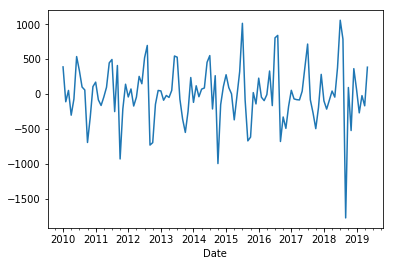

In [18]:
# Lets take differences to see how we can make this stationary
# First Difference
usage['Usage First Difference'] = usage['Usage'] \
                               - usage['Usage'].shift(1)
adf_check(usage['Usage First Difference'].dropna())
usage['Usage First Difference'].plot()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.30059601950027
p-value : 4.028297439435921e-13
#Lags Used : 13
Number of Observations Used : 98
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


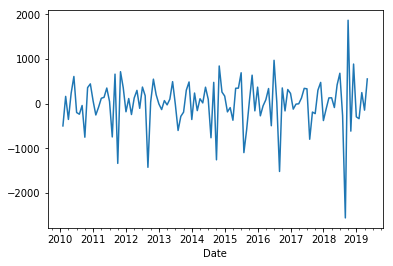

In [19]:
usage['Usage Second Difference'] = usage['Usage First Difference'] \
                               - usage['Usage First Difference'].shift(1)
adf_check(usage['Usage Second Difference'].dropna())
usage['Usage Second Difference'].plot()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.6858218427367313
p-value : 0.004317060578984524
#Lags Used : 12
Number of Observations Used : 89
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


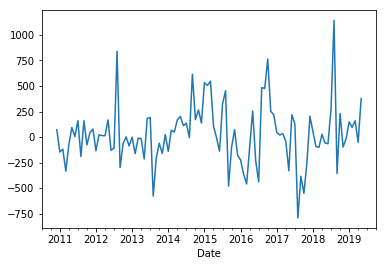

In [20]:
# Seasonal Difference
usage['Seasonal Difference'] = usage['Usage'] \
                            - usage['Usage'].shift(12)
adf_check(usage['Seasonal Difference'].dropna())
usage['Seasonal Difference'].plot()
# Seasonal Difference by itself was not enough!

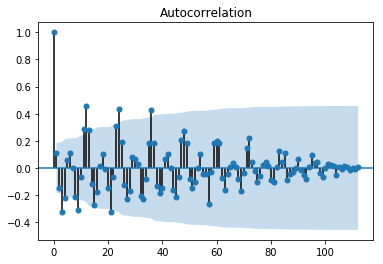

In [21]:
fig_first = plot_acf(usage["Usage First Difference"].dropna())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


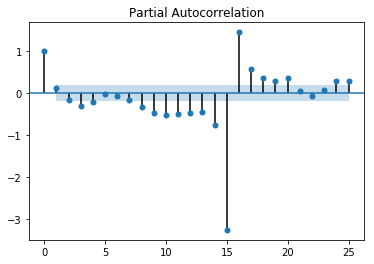

In [22]:
result = plot_pacf(usage["Usage First Difference"].dropna(), lags = 25)

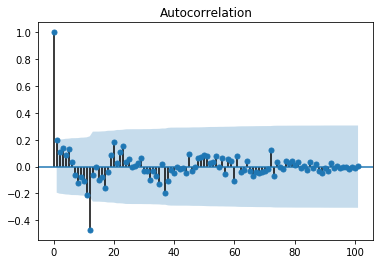

In [23]:
fig_first = plot_acf(usage["Seasonal Difference"].dropna())

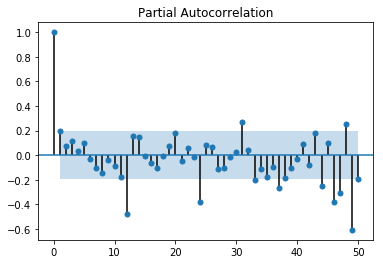

In [24]:
fig_first = plot_pacf(usage["Seasonal Difference"].dropna(), lags=50)

In [25]:
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
grid_results = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(usage['Usage'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            temp = pd.Series({'PDQ':param,'Seasonal PDQ':param_seasonal,'AIC':results.aic,'BIC':results.bic})
            #print (temp)
            grid_results.append(temp) 
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue
            
grid_results = pd.DataFrame(grid_results)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
grid_results.sort_values('AIC', inplace=True)
grid_results.reset_index(inplace=True)
grid_results.head()

,index,PDQ,Seasonal PDQ,AIC,BIC
0,31,"(0, 1, 1)","(1, 1, 1, 12)",1213.374038,1223.237671
1,63,"(1, 1, 1)","(1, 1, 1, 12)",1214.761820,1227.091361
2,27,"(0, 1, 1)","(0, 1, 1, 12)",1215.907226,1223.304950
3,59,"(1, 1, 1)","(0, 1, 1, 12)",1216.939026,1226.802659
4,47,"(1, 0, 1)","(1, 1, 1, 12)",1227.146197,1239.532881


In [28]:
pdq = grid_results.loc[0,'PDQ']
seasonal_pdq = grid_results.loc[0,'Seasonal PDQ']
print (pdq)
print (seasonal_pdq)

(0, 1, 1)
(1, 1, 1, 12)


In [29]:
model = sm.tsa.statespace.SARIMAX(
    usage['Usage']
    ,order=pdq
    ,seasonal_order=seasonal_pdq
    ,enforce_stationarity=False
    ,enforce_invertibility=False
    )
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Usage   No. Observations:                  114
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -602.687
Date:                            Sun, 05 May 2019   AIC                           1213.374
Time:                                    22:34:57   BIC                           1223.238
Sample:                                12-31-2009   HQIC                          1217.346
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8827      0.061    -14.375      0.000      -1.003      -0.762
ar.S.L12      -0.3102      0.113   

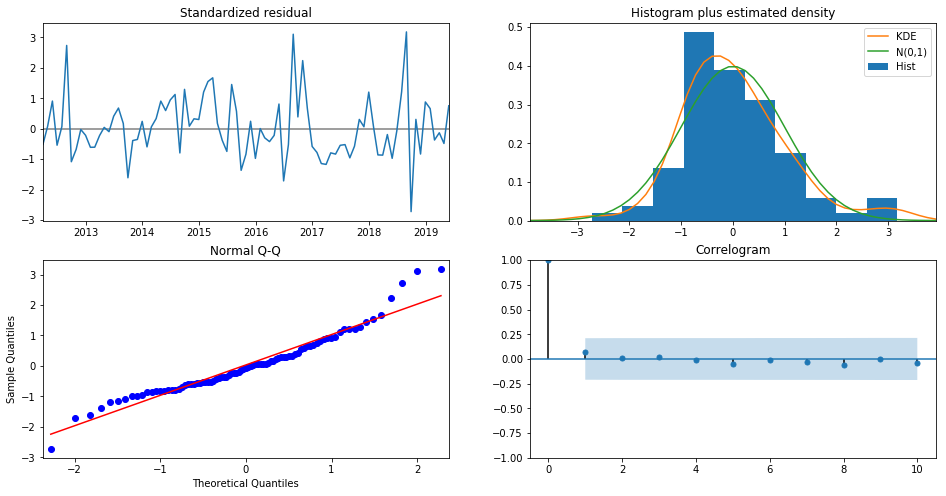

In [30]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [31]:
# Prediction for existing values
usage['Forecast'] = results.predict()  

In [32]:
future_df = pd.DataFrame(columns=usage.columns)
predictions = results.get_forecast(steps=12)
future_df['Forecast'] = predictions.predicted_mean
future_df

,Usage,Usage First Difference,Usage Second Difference,Seasonal Difference,Forecast
2019-06-30,NaN,NaN,NaN,NaN,830.897521
2019-07-31,NaN,NaN,NaN,NaN,1597.941076
2019-08-31,NaN,NaN,NaN,NaN,1809.046275
2019-09-30,NaN,NaN,NaN,NaN,1302.713028
2019-10-31,NaN,NaN,NaN,NaN,821.588917
2019-11-30,NaN,NaN,NaN,NaN,561.276741
2019-12-31,NaN,NaN,NaN,NaN,666.242376
2020-01-31,NaN,NaN,NaN,NaN,699.621551
2020-02-29,NaN,NaN,NaN,NaN,585.704315
2020-03-31,NaN,NaN,NaN,NaN,515.308455


In [33]:
future_df = pd.concat([usage,future_df])
future_df.tail()

,Usage,Usage First Difference,Usage Second Difference,Seasonal Difference,Forecast
2020-01-31,NaN,NaN,NaN,NaN,699.621551
2020-02-29,NaN,NaN,NaN,NaN,585.704315
2020-03-31,NaN,NaN,NaN,NaN,515.308455
2020-04-30,NaN,NaN,NaN,NaN,466.093293
2020-05-31,NaN,NaN,NaN,NaN,547.057983


In [34]:
future_df['Shift 1yr'] = future_df['Usage'].shift(12)
future_df['Shift 2yr'] = future_df['Usage'].shift(24)
future_df['Shift 3yr'] = future_df['Usage'].shift(36)
future_df['Manual Pred'] = np.mean(future_df[['Shift 1yr', 'Shift 2yr','Shift 3yr']], axis = 1) 
   
for col in ['Usage First Difference','Usage Second Difference','Seasonal Difference','Shift 1yr','Shift 2yr','Shift 3yr']:
    if col in future_df:
        del future_df[col]

In [35]:
future_df.tail(14)

,Usage,Forecast,Manual Pred
2019-04-30,342.0,459.076859,389.166667
2019-05-31,727.0,544.792370,498.666667
2019-06-30,NaN,830.897521,697.333333
2019-07-31,NaN,1597.941076,1556.666667
2019-08-31,NaN,1809.046275,2071.333333
2019-09-30,NaN,1302.713028,1163.666667
2019-10-31,NaN,821.588917,920.666667
2019-11-30,NaN,561.276741,518.666667
2019-12-31,NaN,666.242376,675.666667
2020-01-31,NaN,699.621551,684.000000


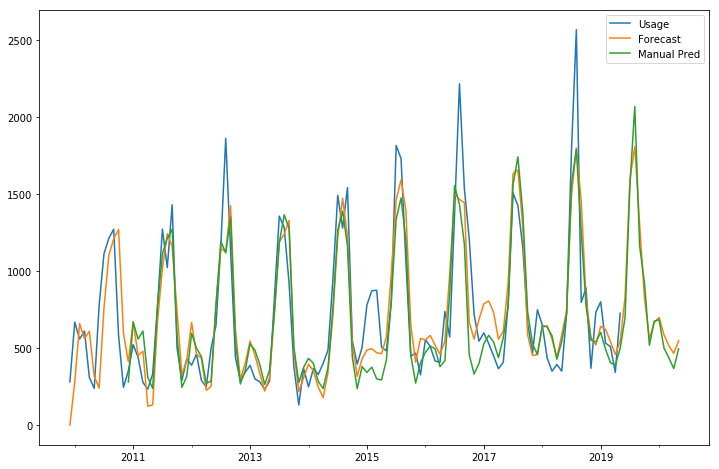

In [36]:
future_df[['Usage', 'Forecast','Manual Pred']].plot(figsize=(12, 8)) 

In [37]:
# Compute the root-mean-square
rms_model = np.sqrt(mean_squared_error(future_df.dropna()['Usage'],future_df.dropna()['Forecast']))
print("Model RMSE: {}".format(rms_model))

rms_manual = np.sqrt(mean_squared_error(future_df.dropna()['Usage'],future_df.dropna()['Manual Pred']))
print("Manual Method (3 yr Average) RMSE: {}".format(rms_manual))

Model RMSE: 236.84789248783554
Manual Method (3 yr Average) RMSE: 243.4929863931566
